In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv
/kaggle/input/icr-identify-age-related-conditions/greeks.csv
/kaggle/input/icr-identify-age-related-conditions/train.csv
/kaggle/input/icr-identify-age-related-conditions/test.csv


In [2]:
from fastai.imports import *
import os
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

%matplotlib inline
import seaborn as sns
from numpy import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from sklearn.ensemble import RandomForestClassifier

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train_df = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/train.csv")
test_df = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/test.csv")
greeks_df = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/greeks.csv")
sample_submission_df = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv")

In [4]:
train_df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.23868,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,B,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.23868,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,A,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.23868,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,B,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.23868,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,B,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.23868,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,B,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [5]:
train_df.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,557.000000,617.000000,617.000000,615.000000,614.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,557.000000,617.000000,617.000000,616.000000,617.000000,617.000000,617.000000,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,21.419492,231.322223,98.328737,1218.133238,550.632525,77.104151,0.688801,90.251735,11.241064,0.030615,1.403761,0.742262,36.917590,1.383792,27.165653,51.128326,401.901299,0.633884,0.367002,146.972099,94.795377,26.370568,1.802900,1.924830,26.388989,9.072700,3.064778,1731.248215,0.305107,69.582596,105.060712,69.117005,71.341526,6.930086,10306.810737,10.111079,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,3.478278,183.992505,96.479371,7575.293707,2076.371275,159.049302,0.263994,51.585130,13.571133,0.014808,1.922210,0.281195,17.266347,0.538717,14.645993,21.210888,317.745623,1.912384,0.112989,86.084419,28.243187,8.038825,9.034721,1.484555,18.116679,6.200281,2.058344,1790.227476,1.847499,38.555707,68.445620,390.187057,165.551545,64.754262,11331.294051,2.934025,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,9.886800,72.948951,1.331155,51.216883,257.432377,12.499760,0.176874,23.387600,0.510888,0.003184,1.050225,0.069225,13.784111,0.137925,7.030640,6.906400,35.998895,0.238680,0.040995,60.232470,10.345600,6.339496,0.005518,1.743070,0.804068,4.926396,0.286201,185.594100,0.003042,5.394675,78.526968,3.828384,7.534128,0.296850,1563.136688,3.583450,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,19.420500,156.847239,27.834425,424.990642,257.432377,23.317567,0.563688,64.724192,5.066306,0.023482,1.050225,0.589575,29.782467,1.070298,7.030640,37.942520,188.815690,0.238680,0.295164,102.703553,78.232240,20.888264,0.005518,1.743070,14.715792,5.965392,1.648679,1111.160625,0.003042,30.927468,78.526968,4.324656,25.815384,0.296850,5164.666260,8.523098,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,21.186000,193.908816,61.642115,627.417402,257.432377,42.554330,0.658715,79.819104,9.123000,0.027860,1.050225,0.730800,34.835130,1.351665,36.019104,49.180940,307.509595,0.238680,0.358023,130.050630,96.264960,25.248800,0.251741,1.743070,21.642456,8.149404,2.616119,1493.817413,0.085176,71.949306,78.526968,22.641144,36.394008,1.870155,7345.143424,9.945452,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,23.657700,247.803462,134.009015,975.649259,257.432377,77.310097,0.772206,99.813520,13.565901,0.034427,1.228445,0.859350,40.529401,1.660617,37.935832,61.408760,507.896200,0.238680,0.426348,165.836955,110.640680,30.544224,1.058690,1.743070,34.058344,10.503048,3.910070,1905.701475,0.237276,109.125159,112.766654,49.085352,56.714448,4.88021

<Axes: ylabel='Class'>

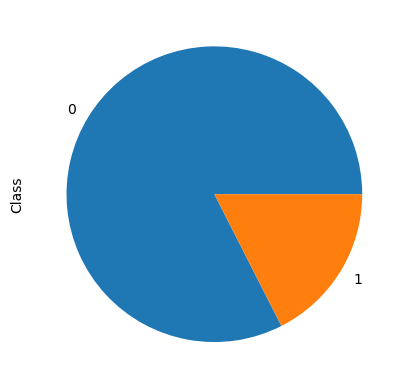

In [6]:
train_df.Class.value_counts().plot.pie()

In [7]:
train_df.isna().sum()

Id        0
AB        0
AF        0
AH        0
AM        0
AR        0
AX        0
AY        0
AZ        0
BC        0
BD        0
BN        0
BP        0
BQ       60
BR        0
BZ        0
CB        2
CC        3
CD        0
CF        0
CH        0
CL        0
CR        0
CS        0
CU        0
CW        0
DA        0
DE        0
DF        0
DH        0
DI        0
DL        0
DN        0
DU        1
DV        0
DY        0
EB        0
EE        0
EG        0
EH        0
EJ        0
EL       60
EP        0
EU        0
FC        1
FD        0
FE        0
FI        0
FL        1
FR        0
FS        2
GB        0
GE        0
GF        0
GH        0
GI        0
GL        1
Class     0
dtype: int64

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

In [9]:
modes = train_df.mode().iloc[0]

In [10]:
def process_data(df):
    df.fillna(modes, inplace=True)
    df["EJ"] = pd.Categorical(df.EJ)
    
process_data(train_df)
process_data(test_df)

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Id      617 non-null    object  
 1   AB      617 non-null    float64 
 2   AF      617 non-null    float64 
 3   AH      617 non-null    float64 
 4   AM      617 non-null    float64 
 5   AR      617 non-null    float64 
 6   AX      617 non-null    float64 
 7   AY      617 non-null    float64 
 8   AZ      617 non-null    float64 
 9   BC      617 non-null    float64 
 10  BD      617 non-null    float64 
 11  BN      617 non-null    float64 
 12  BP      617 non-null    float64 
 13  BQ      617 non-null    float64 
 14  BR      617 non-null    float64 
 15  BZ      617 non-null    float64 
 16  CB      617 non-null    float64 
 17  CC      617 non-null    float64 
 18  CD      617 non-null    float64 
 19  CF      617 non-null    float64 
 20  CH      617 non-null    float64 
 21  CL      617 non-

In [12]:
train_df.EJ.head(), train_df.EJ.cat.codes.head()

(0    B
 1    A
 2    B
 3    B
 4    B
 Name: EJ, dtype: category
 Categories (2, object): ['A', 'B'],
 0    1
 1    0
 2    1
 3    1
 4    1
 dtype: int8)

In [13]:
categoricals = ["EJ"]
dependent = "Class"
conts = [column for column in train_df.columns if not column in categoricals + [dependent] + ["Id"]]

[Text(0.5, 1.0, 'Histogram')]

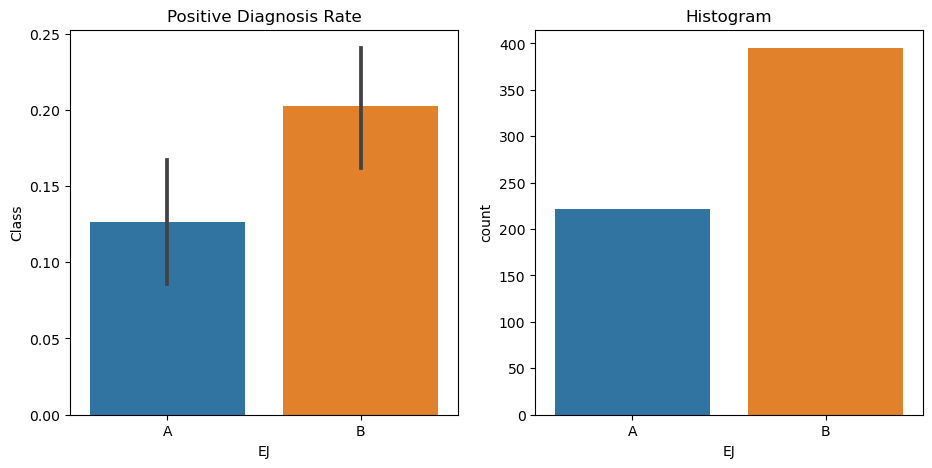

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(11, 5))
sns.barplot(data=train_df, y=dependent, x="EJ", ax=axs[0]).set(title="Positive Diagnosis Rate")
sns.countplot(data=train_df, x="EJ", ax=axs[1]).set(title="Histogram")

<Axes: xlabel='AB', ylabel='Density'>

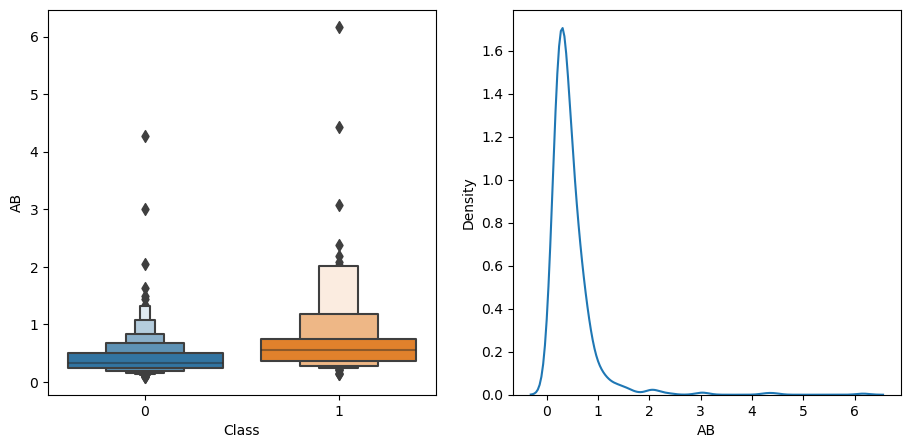

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))
sns.boxenplot(data=train_df, x=dependent, y="AB", ax=ax1)
sns.kdeplot(data=train_df, x="AB", ax=ax2)

In [16]:
def score(col, y, split_value):
    lhs = col <= split_value
    return (_side_score(lhs, y) + _side_score(~lhs, y))/len(y)

def _side_score(side, y):
    count = side.sum()
    if count <=1: return 0
    return y[side].std() * count 

In [17]:
score(train_df.AB, train_df[dependent], 0.5)

0.36017711175753037

In [18]:
train_df_n = train_df.copy()
train_df_n[categoricals] = train_df_n[categoricals].apply(lambda x: x.cat.codes)
train_df_n[categoricals].head()

,EJ
0,1
1,0
2,1
3,1
4,1


In [19]:
score(train_df_n.EJ, train_df_n[dependent], 1)

0.3803100751041243

In [20]:
col = train_df_n["AB"]
y = train_df_n[dependent]
uniques = col.unique()
uniques.sort()
uniques[:50]

array([0.081187 , 0.08546  , 0.098279 , 0.102552 , 0.111098 , 0.119644 ,
       0.1217805, 0.1303265, 0.132463 , 0.136736 , 0.141009 , 0.145282 ,
       0.149555 , 0.153828 , 0.1559645, 0.158101 , 0.1602375, 0.162374 ,
       0.166647 , 0.17092  , 0.175193 , 0.179466 , 0.183739 , 0.1858755,
       0.188012 , 0.1901485, 0.192285 , 0.196558 , 0.200831 , 0.2029675,
       0.205104 , 0.209377 , 0.21365  , 0.217923 , 0.222196 , 0.2243325,
       0.226469 , 0.230742 , 0.235015 , 0.239288 , 0.243561 , 0.247834 ,
       0.252107 , 0.25638  , 0.260653 , 0.2627895, 0.264926 , 0.269199 ,
       0.2713355, 0.273472 ])

In [21]:
scores = np.array([score(col, y, split) for split in uniques])
uniques[scores.argmin()]

0.410208

In [22]:
def min_column(df, col_name):
    col, y = df[col_name], df[dependent]
    uniques = col.unique()
    scores = np.array([score(col, y, split) for split in uniques])
    index = scores.argmin()
    return uniques[index], scores[index]

In [23]:
min_column(train_df_n, "AB")

(0.410208, 0.3561906829723693)

In [24]:
min_column(train_df_n, "EJ")

(0, 0.3773339803468088)

In [25]:
columns = conts + categoricals
splits = {col: min_column(train_df_n, col) for col in columns}

In [26]:
splits

{'AB': (0.410208, 0.3561906829723693),
 'AF': (2808.64232, 0.35583548065304915),
 'AH': (193.801377, 0.3761985927636321),
 'AM': (149.318758, 0.367338331639673),
 'AR': (16.327194, 0.3678281215243884),
 'AX': (17.877462, 0.37677322461475915),
 'AY': (0.6019965, 0.37677322461475915),
 'AZ': (10.971782, 0.3782810033906922),
 'BC': (13.500788, 0.35968813799570454),
 'BD ': (12083.34891, 0.3749922782916859),
 'BN': (21.186, 0.3651185274145938),
 'BP': (196.710795, 0.3725348222558456),
 'BQ': (115.695865, 0.3668876611761174),
 'BR': (3466.745415, 0.374094640781585),
 'BZ': (2885.319798, 0.376211243844383),
 'CB': (13.32695, 0.37775055805021784),
 'CC': (0.5478777, 0.3665150807004323),
 'CD ': (85.955376, 0.3635292346687648),
 'CF': (1.8504485, 0.367406050093466),
 'CH': (0.016318, 0.3782672405025747),
 'CL': (1.24754, 0.37657306471010377),
 'CR': (0.527325, 0.35228611051878406),
 'CS': (62.2516675, 0.37277362672289577),
 'CU': (1.274427, 0.37534114864714596),
 'CW ': (35.67944, 0.3772898765

In [27]:
min_score = 1
for k, v in splits.items():
    if v[1] < min_score:
        min_score = v[1]
        min_score_column = k
min_score_column, splits[min_score_column]

('DU', (2.27601, 0.3207517917154871))

In [28]:
random.seed(42)
model_train, model_val = train_test_split(train_df_n,  test_size=0.25)

In [29]:
model_train.shape, model_val.shape

((462, 58), (155, 58))

In [30]:
def x_y(df):
    return df[conts + categoricals], df[dependent]

model_train_x, model_train_y = x_y(model_train)
model_val_x, model_val_y = x_y(model_val)

In [31]:
one_r_splits = {col: min_column(model_train, col) for col in model_train_x.columns}

In [32]:
one_r_splits

{'AB': (0.581128, 0.3500151266645586),
 'AF': (2807.2121, 0.3482960305933906),
 'AH': (196.117971, 0.37031622929971825),
 'AM': (113.124119, 0.3677805771621117),
 'AR': (15.870966, 0.36607803019531715),
 'AX': (17.877462, 0.3701715230565572),
 'AY': (0.038976, 0.372511904676532),
 'AZ': (23.626198, 0.3735437010139049),
 'BC': (13.500788, 0.35865783745331065),
 'BD ': (10563.27538, 0.37017152305655715),
 'BN': (20.8329, 0.36082123208699335),
 'BP': (282.245337, 0.36079488319104713),
 'BQ': (69.65249, 0.36180119785038894),
 'BR': (5161.327397, 0.36527011004085347),
 'BZ': (2885.319798, 0.36963503519601426),
 'CB': (12.931737, 0.37244503925274197),
 'CC': (0.61375644, 0.3617285103240913),
 'CD ': (85.68186, 0.3631411826566342),
 'CF': (1.8504485, 0.36160897217069404),
 'CH': (0.012338, 0.3725637613110524),
 'CL': (1.24754, 0.3725459888575431),
 'CR': (0.527325, 0.34941117879168376),
 'CS': (62.2516675, 0.3671272819598272),
 'CU': (1.125468, 0.366462462615929),
 'CW ': (35.67944, 0.3672847

In [33]:
def get_best_split(splits):
    min_score = 1
    for k, v in splits.items():
        if v[1] < min_score:
            min_score = v[1]
            min_score_column = k
    return min_score_column, splits[min_score_column]

column, split = get_best_split(one_r_splits)
column, split

('DU', (2.262216, 0.3196074664465314))

In [34]:
preds = model_val_x["DU"] <= 2.262216

In [35]:
mean_absolute_error(model_val_y, preds)

0.864516129032258

In [36]:
def balanced_logarithmic_loss(y_true, y_pred):
    N_1 = np.sum(y_true == 1, axis=0)
    N_0 = np.sum(y_true == 0, axis=0)

    y_pred = np.maximum(np.minimum(y_pred, 1 - 1e-15), 1e-15)
    loss_numerator = - (1/N_0) * np.sum((1 - y_true) * np.log(1-y_pred)) - (1/N_1) * np.sum(y_true * np.log(y_pred))

    return loss_numerator / 2

balanced_logarithmic_loss(model_val_y.to_numpy(), preds.to_numpy())

25.950508209640226

In [37]:
lhs = model_train["DU"] <= 2.262216
left_group = model_train[lhs]
right_group = model_train[~lhs]
left_group.shape, right_group.shape

((396, 58), (66, 58))

In [38]:
second_level_columns = [c for c in (conts + categoricals) if c != "DU"]
left_splits = {col: min_column(left_group, col) for col in second_level_columns}
right_splits = {col: min_column(right_group, col) for col in second_level_columns}
left_splits, right_splits

({'AB': (0.363205, 0.2205227532918278),
  'AF': (1744.8442, 0.26422367520400314),
  'AH': (186.276801, 0.28281828339030296),
  'AM': (16.333578, 0.2678889313583875),
  'AR': (15.870966, 0.2866140712941824),
  'AX': (5.244528, 0.2773853964685262),
  'AY': (0.6019965, 0.2874443162878375),
  'AZ': (8.186298, 0.2851965412728709),
  'BC': (13.500788, 0.254228411937528),
  'BD ': (10563.27538, 0.28342483094474047),
  'BN': (15.1833, 0.2815221656802702),
  'BP': (318.7728, 0.27010283692431253),
  'BQ': (11.865775, 0.2794184862139197),
  'BR': (5161.327397, 0.2752096532354187),
  'BZ': (1703.832302, 0.28396363710150363),
  'CB': (12.931737, 0.28032816063022753),
  'CC': (0.61375644, 0.2699890428677908),
  'CD ': (88.048368, 0.2693262549530457),
  'CF': (2.548358, 0.27644641567153155),
  'CH': (0.016716, 0.2836102268644721),
  'CL': (1.152065, 0.2817474069769845),
  'CR': (0.6729, 0.25077109773069917),
  'CS': (55.8007175, 0.2831938474420979),
  'CU': (1.059264, 0.2763697098465586),
  'CW ': (4

In [39]:
best_left_split = get_best_split(left_splits)
best_right_split = get_best_split(right_splits)
best_left_split, best_right_split

(('AB', (0.363205, 0.2205227532918278)),
 ('GL', (0.047863636, 0.40470758822889663)))

In [40]:
model = DecisionTreeClassifier(max_leaf_nodes=4).fit(model_train_x, model_train_y)

In [41]:
def draw_tree(tree, df, size=10, ratio=0.6, precision=2, **kwargs):
    dot_format = export_graphviz(tree, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                                special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', dot_format))

In [42]:
#draw_tree(model, model_train_x, size=10)

In [43]:
def gini(df, condition):
    actual = df.loc[condition, dependent]
    return 1 - actual.mean()**2 - (1-actual).mean()**2

In [44]:
gini(model_train, model_train['DU'] <= 2.28), gini(model_train, model_train['DU'] > 2.28)

(0.16940873380267307, 0.47061524334251614)

In [45]:
preds = model.predict(model_val_x)
mean_absolute_error(model_val_y, preds)

0.11612903225806452

In [46]:
balanced_logarithmic_loss(model_val_y.to_numpy(), preds)

5.549265256402579

In [47]:
model = DecisionTreeClassifier(min_samples_leaf=50)
model.fit(model_train_x, model_train_y)
#draw_tree(model, model_train_x, size=12)

DecisionTreeClassifier(min_samples_leaf=50)

In [48]:
preds = model.predict(model_val_x)

mean_absolute_error(model_val_y, preds), balanced_logarithmic_loss(model_val_y.to_numpy(), preds)

(0.12903225806451613, 8.450509680016193)

In [49]:
def get_tree(proportion=0.75):
    n = len(model_train_y)
    indexes = random.choice(n, int(n*proportion))
    return DecisionTreeClassifier(min_samples_leaf=5).fit(model_train_x.iloc[indexes], model_train_y.iloc[indexes])  

In [50]:
trees = [get_tree() for _ in range(100)]
trees[:5]

[DecisionTreeClassifier(min_samples_leaf=5),
 DecisionTreeClassifier(min_samples_leaf=5),
 DecisionTreeClassifier(min_samples_leaf=5),
 DecisionTreeClassifier(min_samples_leaf=5),
 DecisionTreeClassifier(min_samples_leaf=5)]

In [51]:
all_preds = [t.predict(model_val_x) for t in trees]
avg_preds = np.stack(all_preds).mean(axis=0)

In [52]:
mean_absolute_error(model_val_y, avg_preds), balanced_logarithmic_loss(model_val_y.to_numpy(), avg_preds)

(0.1665806451612903, 0.4201347888809029)

In [53]:
rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=5)
rf.fit(model_train_x, model_train_y)

preds =  rf.predict(model_val_x)


mean_absolute_error(model_val_y, preds), balanced_logarithmic_loss(model_val_y.to_numpy(), preds)

(0.05806451612903226, 5.180816459236603)

In [54]:
test_df_n = test_df.copy()
test_df_n[categoricals] = test_df_n[categoricals].apply(lambda x: x.cat.codes)
test_df_n[categoricals].head()

,EJ
0,0
1,0
2,0
3,0
4,0


In [55]:
columns = conts + categoricals
test_probs = rf.predict_proba(test_df_n[columns])
test_probs

array([[0.58356527, 0.41643473],
       [0.58356527, 0.41643473],
       [0.58356527, 0.41643473],
       [0.58356527, 0.41643473],
       [0.58356527, 0.41643473]])

In [56]:
sample_submission_df[["class_0", "class_1"]] = test_probs

In [57]:
sample_submission_df.to_csv("submission.csv", index=False)

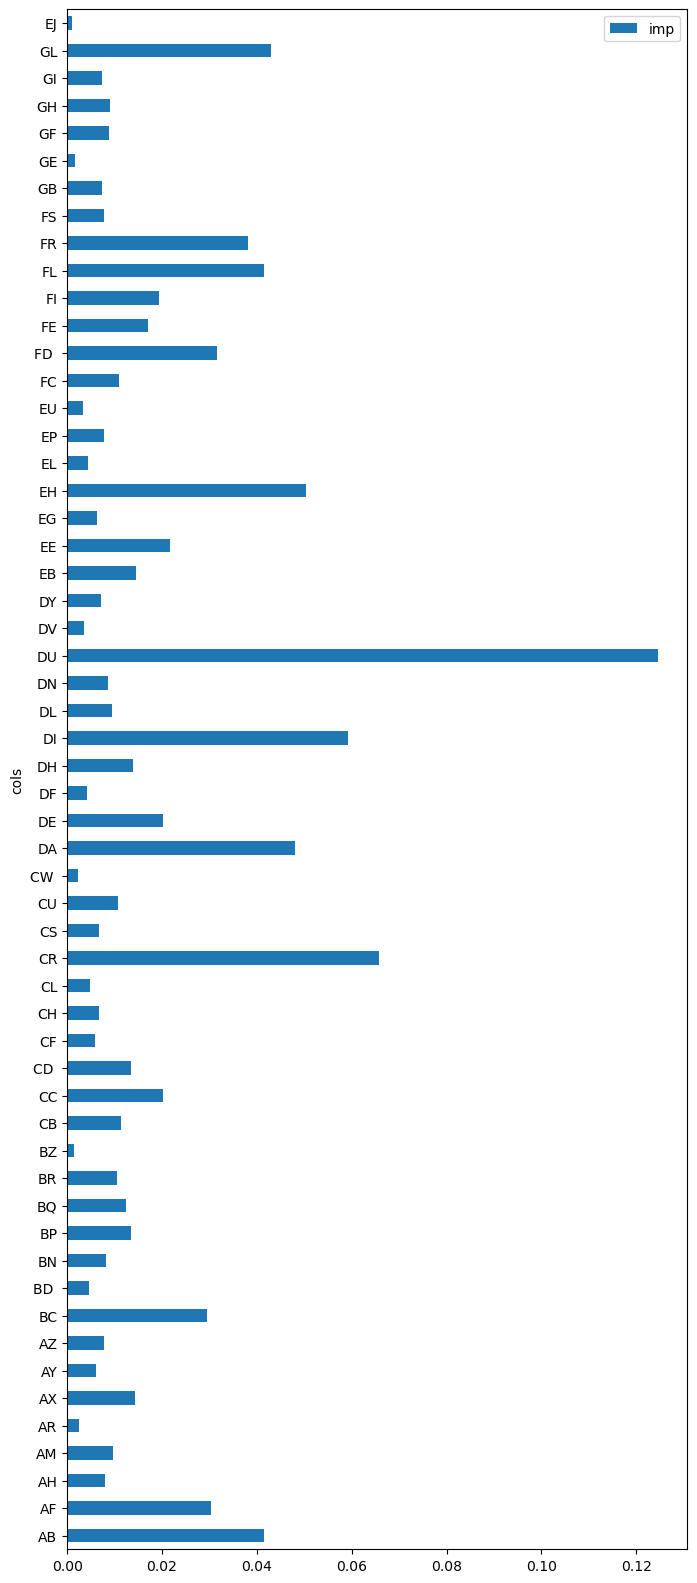

In [58]:
pd.DataFrame(dict(cols=model_train_x.columns, imp=rf.feature_importances_)).plot('cols', 'imp', 'barh', figsize=(8, 20));

In [59]:
sample_submission_df.head()

,Id,class_0,class_1
0,00eed32682bb,0.583565,0.416435
1,010ebe33f668,0.583565,0.416435
2,02fa521e1838,0.583565,0.416435
3,040e15f562a2,0.583565,0.416435
4,046e85c7cc7f,0.583565,0.416435
